<a href="https://colab.research.google.com/github/sergiyromanenko/CV-HW/blob/master/lesson_13/DayNightClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Day-Night Image Classification

In this notebook, we will implement a DNN classifier to classify images taken by stationary cameras as day or night images. We will also establish a baseline to make sure our deep learning implementation outperforms a simple hand-picked feature-based classification.

In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras import Model

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 6]

In [7]:
cd sample_data/


/content/sample_data


#### Dataset Loading

We will use the day-night image dataset that you can download from [here](https://www.kaggle.com/datasets/stevemark/daynight-dataset?resource=download). (118 Mb zip archive)

In [8]:
!unzip ./archive.zip

Archive:  ./archive.zip
  inflating: DNIM/Image/00000850/20151101_072507.jpg  
  inflating: DNIM/Image/00000850/20151101_075502.jpg  
  inflating: DNIM/Image/00000850/20151101_082503.jpg  
  inflating: DNIM/Image/00000850/20151101_085511.jpg  
  inflating: DNIM/Image/00000850/20151101_092511.jpg  
  inflating: DNIM/Image/00000850/20151101_095505.jpg  
  inflating: DNIM/Image/00000850/20151101_105513.jpg  
  inflating: DNIM/Image/00000850/20151101_112505.jpg  
  inflating: DNIM/Image/00000850/20151101_115515.jpg  
  inflating: DNIM/Image/00000850/20151101_122510.jpg  
  inflating: DNIM/Image/00000850/20151101_125509.jpg  
  inflating: DNIM/Image/00000850/20151101_132459.jpg  
  inflating: DNIM/Image/00000850/20151101_135513.jpg  
  inflating: DNIM/Image/00000850/20151101_142506.jpg  
  inflating: DNIM/Image/00000850/20151101_145511.jpg  
  inflating: DNIM/Image/00000850/20151101_152512.jpg  
  inflating: DNIM/Image/00000850/20151101_155521.jpg  
  inflating: DNIM/Image/00000850/20151101

In [10]:
# Get the different video sequences
folder = './DNIM'
sequences = [os.path.splitext(f)[0] for f in os.listdir(os.path.join(folder, 'time_stamp'))]

#### Dataset Visualization

Let's now visualize some random data and the corresponding labels to see what we are dealing with here.

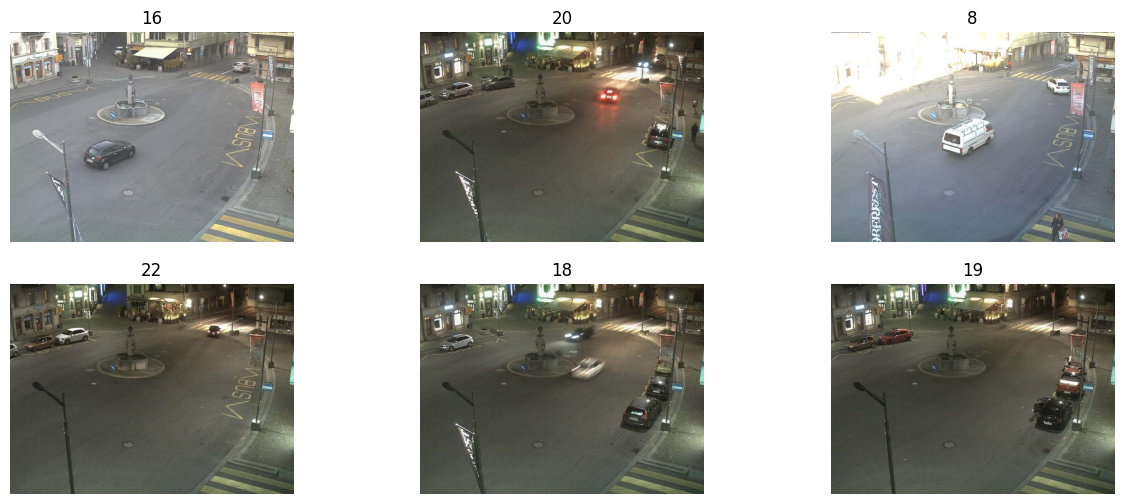

In [11]:
sequence = sequences[2]

with open(os.path.join(folder, 'time_stamp', sequence + '.txt'), 'r') as fid:
    data = fid.readlines()
data = [d.strip() for d in data]

fnames = [d.split(' ')[0] for d in data]
hours = [int(d.split(' ')[-2]) for d in data]

for cnt, idx in enumerate(np.random.randint(0, len(fnames), 6)):
    image = cv2.imread(os.path.join(folder, 'Image', sequence, fnames[idx]))
    plt.subplot(2, 3, cnt + 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(hours[idx]), plt.axis(False)

#### Data Preprocessing

Now we will prepare the data for the training. That means that we load all the images, downsample them to a more treatable size and prepare the binary annotations.

In [12]:
size = 64
images, labels = [], []

for sequence in tqdm(sequences):
    # Read annotation file
    with open(os.path.join(folder, 'time_stamp', sequence + '.txt'), 'r') as fid:
        data = fid.readlines()

    # Extract information
    data = [d.strip() for d in data]
    fnames = [d.split(' ')[0] for d in data]
    hours = [int(d.split(' ')[-2]) for d in data]

    # Prepare training data
    images = images + [cv2.cvtColor(cv2.resize(cv2.imread(os.path.join(folder, 'Image', sequence, f)),
                                  (size, size)), cv2.COLOR_BGR2RGB) for f in fnames]
    labels = labels + hours

images = np.array(images)/255
labels = np.array(labels)

images.shape, labels.shape

100%|██████████| 17/17 [00:12<00:00,  1.33it/s]


((1722, 64, 64, 3), (1722,))

In [13]:
# Divide the data into day and night images
labels = np.array([1 if (l <= 6 or l >= 18) else 0 for l in labels])

# Are the two classes balanced?
print('Num day images:  ', np.sum(labels == 0))
print('Num night images:', np.sum(labels == 1))

Num day images:   786
Num night images: 936


Let's now shuffle the data and visualize them one last time.

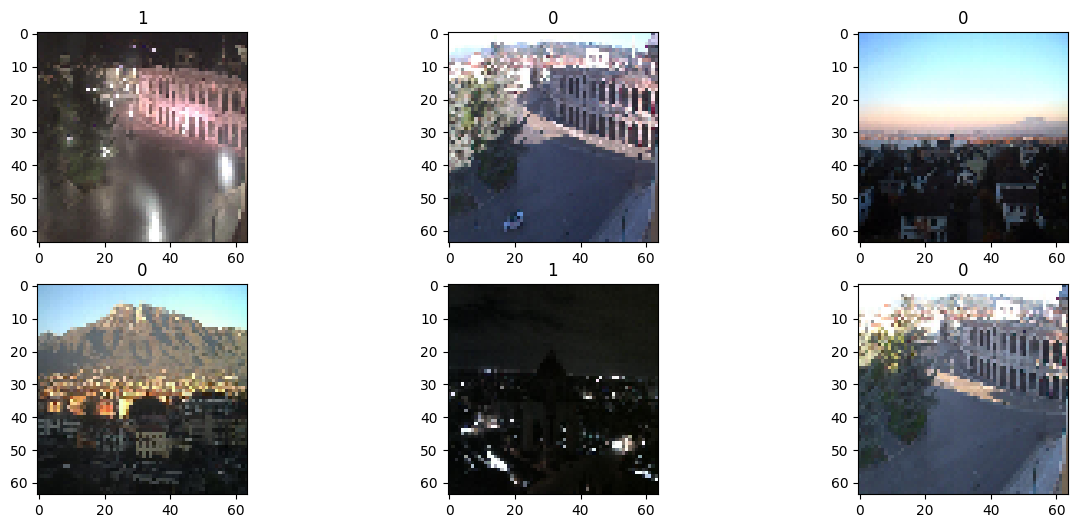

In [14]:
images, labels = shuffle(images, labels)
for cnt, idx in enumerate(np.random.randint(0, len(images), 6)):
    plt.subplot(2, 3, cnt + 1), plt.imshow(images[idx], vmin=0, vmax=1), plt.title(labels[idx])

#### Build the Baseline

Before we start training our neural network based model, we might need to establish a performance baseline. We do so to be able to tell whether the model is actually good or not.

Since we are dealing with a day-night problem, the most straightforward approach is to use the mean color (or even luminance) to classify images as day vs night. So let's do it :-)

(<matplotlib.legend.Legend at 0x7e4612bf7a30>,
 Text(0.5, 0, 'average color'),
 None)

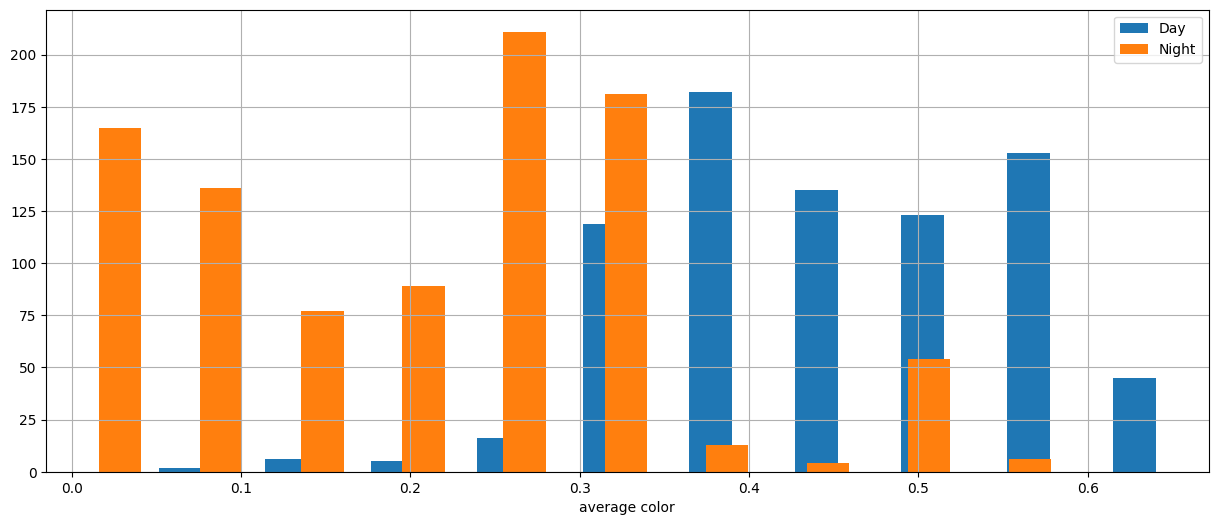

In [15]:
# Compute mean color values for each image
mu_day = [np.mean(i) for i, l in zip(images, labels) if l == 0]
mu_night = [np.mean(i) for i, l in zip(images, labels) if l == 1]

# Visualize the histograms of the obtained mean colors. Are they well separated?
counts_day, bins_day = np.histogram(mu_day, bins=10)
counts_night, bins_night = np.histogram(mu_night, bins=10)

plt.bar(bins_day[0:-1], counts_day, width=0.025)
plt.bar(bins_night[0:-1], counts_night, width=0.025)
plt.legend(['Day', 'Night']), plt.xlabel('average color'), plt.grid(True)

The histograms do not seem that well separated. Anyway, let's find the optimal threshold that maximizes the classification accuracy.

(Text(0.5, 0, 'threshold'), Text(0, 0.5, 'accuracy'))

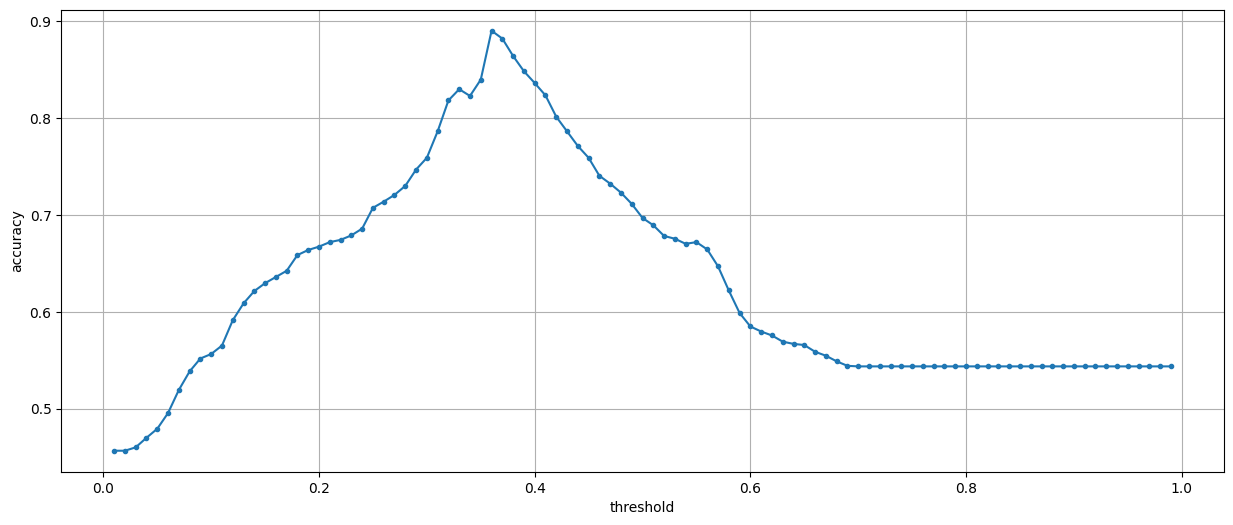

In [16]:
acc = []
thresholds = np.arange(0.01, 1, 0.01)

for th in thresholds:
    acc.append((np.sum(mu_day >= th) + np.sum(mu_night < th)) / len(labels))

plt.plot(thresholds, acc, '.-'), plt.grid(True)
plt.xlabel('threshold'), plt.ylabel('accuracy')

#### Binary Classifier Based on Neural Networks

Let's now build a NN-based classifier and let's see if we can beat the baseline.

In [17]:
inputs = Input(shape=(size, size, 3))

net = Flatten()(inputs)
net = Dense(16, activation='relu')(net)
outputs = Dense(1, activation='sigmoid')(net)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 16)                196624    
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 196641 (768.13 KB)
Trainable params: 196641 (768.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Let's compile the model and start training.

In [18]:
epochs = 25
batch_size = 128

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
history = model.fit(images, labels, batch_size=batch_size, epochs=epochs)

Epoch 1/25
14/14 [==============================] - 1s 18ms/step - loss: 0.4369 - accuracy: 0.5447
Epoch 2/25
14/14 [==============================] - 0s 16ms/step - loss: 0.4564 - accuracy: 0.5436
Epoch 3/25
14/14 [==============================] - 0s 17ms/step - loss: 0.4564 - accuracy: 0.5436
Epoch 4/25
14/14 [==============================] - 0s 16ms/step - loss: 0.4564 - accuracy: 0.5436
Epoch 5/25
14/14 [==============================] - 0s 15ms/step - loss: 0.4564 - accuracy: 0.5436
Epoch 6/25
14/14 [==============================] - 0s 15ms/step - loss: 0.4564 - accuracy: 0.5436
Epoch 7/25
14/14 [==============================] - 0s 15ms/step - loss: 0.4564 - accuracy: 0.5436
Epoch 8/25
14/14 [==============================] - 0s 16ms/step - loss: 0.4564 - accuracy: 0.5436
Epoch 9/25
14/14 [==============================] - 0s 14ms/step - loss: 0.4564 - accuracy: 0.5436
Epoch 10/25
14/14 [==============================] - 0s 15ms/step - loss: 0.4564 - accuracy: 0.5436
Epoch 11/

(<Axes: title={'center': 'accuracy'}, xlabel='epoch'>,
 None,
 Text(0.5, 0, 'epoch'),
 Text(0.5, 1.0, 'accuracy'))

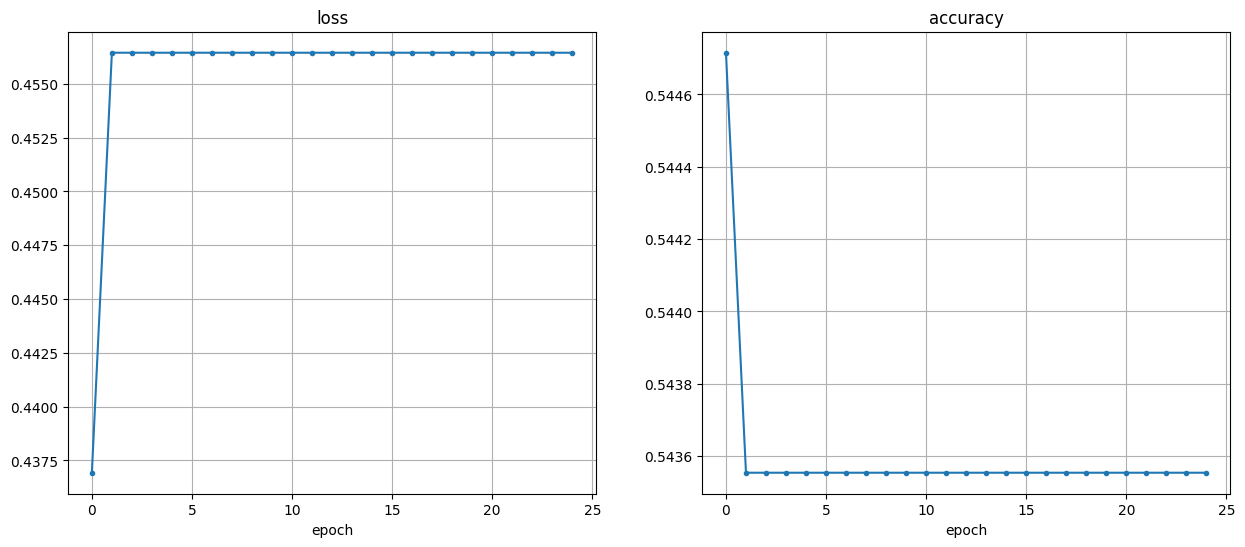

In [19]:
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-'), plt.grid(True), plt.xlabel('epoch'), plt.title('loss')
plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-'), plt.grid(True), plt.xlabel('epoch'), plt.title('accuracy')

In [20]:
y_true = labels.flatten()
y_pred = model.predict(images).flatten()

y_pred_ = y_pred > 0.5

# Overall accuracy
num_samples = len(y_true)
acc = np.sum(y_true == y_pred_)/num_samples

# Accuracy for digit 0
mask = y_true == 0
acc0 = np.sum(y_true[mask] == y_pred_[mask])/np.sum(mask)

# Accuracy for digit 1
mask = y_true == 1
acc1 = np.sum(y_true[mask] == y_pred_[mask])/np.sum(mask)

print('Overall acc', acc)
print('Digit-0 acc', acc0)
print('Digit-1 acc', acc1)

54/54 [==============================] - 0s 3ms/step
Overall acc 0.5435540069686411
Digit-0 acc 0.0
Digit-1 acc 1.0


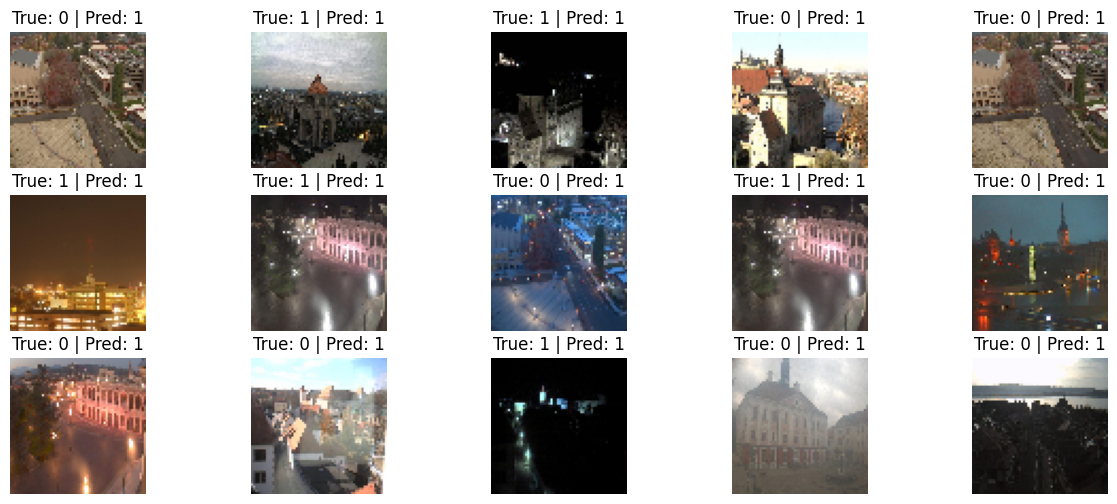

In [21]:
# Visualisation
for ii in range(15):
    idx = np.random.randint(0, len(y_pred))
    plt.subplot(3,5,ii+1), plt.imshow(images[idx, ...]), plt.axis(False)
    plt.title('True: ' + str(y_true[idx]) + ' | Pred: ' + str(int(y_pred_[idx])))